In [1]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm

import torchvision.models as models
from torch.nn import Module, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision

#from pytorchtools import EarlyStopping



from torchvision import datasets, models, transforms
import time
import logging

#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV



In [3]:
train_transforms = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.5),
                                    transforms.ToTensor()])


val_transforms= transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor()])



# cross validaion with 5 folders on the train 
train_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/', train_transforms) 

# cross validaion with 5 folders on the val 
val_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/val/', val_transforms) 


batch_size = 48
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=True)

                         

In [5]:
#chesk the classes 
#train_dataset.classes


In [6]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

In [7]:
#model.eval()

In [4]:
class VGG_19_Regression(Module):
    
    def __init__(self,):
        
        model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)
        
        super(VGG_19_Regression,self).__init__()
        self.model= model
        self.Regression = nn.Linear(1000,1)
        self.dropout = Dropout(0.5)
        
           
         
    def forward(self, out):
        
        x= self.model(out)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.dropout(x)
        
        x =self.Regression(x)
        
        return x

In [9]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Model = models.vgg19(pretrained=True).features.to(device).eval()

In [5]:
Model= VGG_19_Regression()

MSE = torch.nn.MSELoss()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.00001,momentum=0.9)


Using cache found in /Users/eudari01/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
#train_accuracy=[]
train_loss = []
val_loss = []

def training(epoch):
      
    for i in range(5) : 
     
        
      
        epoch_loss = 0.0
        running_loss_train=0.0
   
        for data, label in tqdm(train_loader):
        
            label= label.to(torch.float32)
            label = label.unsqueeze(1)

         
        #Transfer Data to GPU if available
        #if torch.cuda.is_available():
            #data = data.cuda()
            #label = label.cuda()
            #Model.train()
            output = Model(data)
            #you can change the loss and use MSE or Cross Entropy
            loss = MSE(output,label)
           
            # Clear the gradients
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            #Calculate accuracy 
            #prediction_train=output.argmax(dim=1)
           # acc = (prediction_train== label1).float().mean()
        
            running_loss_train =+ loss.item()* data.size(0) 
            #Epoch
            #epoch_accuracy += acc.item() / len(train_loader)
            epoch_loss += running_loss_train / len(train_loader)
            
            
        Model.eval()
        epoch_val_loss = 0.0
        running_loss_val= 0.0
        
  
        
        for data, label in valid_loader:
            #if torch.cuda.is_available():
                
                #data = data.cuda()
                #label = label.cuda()
                #label= label.to(torch.float32)
                #label = label.unsqueeze(1)
    
                output = Model(data)
                
                loss = MSE(output, label)
                
                # Clear the gradients
                #optimizer.zero_grad()
                
                #val_loss.backward()
                
                #optimizer.step()
                #Calculate accuracy 
                #prediction_val= val_output.argmax(dim=1)
                
                #mse_val=mean_squared_error(label,prediction_val)
                
                #val_acc = (prediction_val == label).float().mean()
                
                running_loss_val =+ loss.item()* data.size(0) 
               
                #Epoch
                #epoch_val_accuracy += val_acc.item() / len(valid_loader)
                epoch_val_loss += running_loss_val / len(valid_loader)

                    
            
        val_loss.append(epoch_val_loss)
        train_loss.append(epoch_loss)
    #train_accuracy.append(epoch_accuracy)
        #print('Split: {}'.format(i))                
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} \n")

In [7]:
epochs=5
for epoch in range(1,epochs+1):
     training(epoch)

100%|███████████████████████████████████████████| 61/61 [17:18<00:00, 17.03s/it]
/Users/eudari01/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/eudari01/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 198.5318 - val_loss : 104.6466 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 104.3880 - val_loss : 101.2743 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 102.6392 - val_loss : 93.1937 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 100.5850 - val_loss : 95.7866 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 99.0143 - val_loss : 94.2361 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 98.7961 - val_loss : 104.8711 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 98.2802 - val_loss : 91.5123 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 97.1217 - val_loss : 93.2084 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 96.7735 - val_loss : 91.4922 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 97.1342 - val_loss : 91.1122 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 97.3862 - val_loss : 93.6766 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 97.6438 - val_loss : 91.8514 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 96.4948 - val_loss : 90.1754 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 97.0111 - val_loss : 91.9637 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 95.9387 - val_loss : 91.5774 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.6626 - val_loss : 92.1217 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.1591 - val_loss : 92.9518 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.0044 - val_loss : 90.3634 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.0132 - val_loss : 91.3176 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 95.1435 - val_loss : 89.9238 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 95.8815 - val_loss : 89.8418 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 97.1110 - val_loss : 90.6401 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 96.0611 - val_loss : 91.0066 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 95.0228 - val_loss : 90.3243 



100%|███████████████████████████████████████████| 61/61 [16:08<00:00, 15.88s/it]


Epoch : 6 - train_loss : 96.3428 - val_loss : 91.4109 



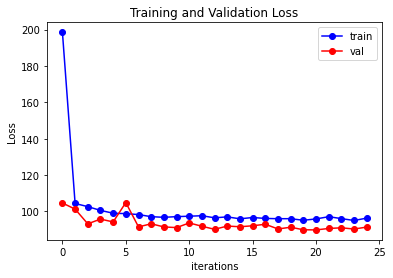

In [8]:
# to check the overfiting 
plt.title("Training and Validation Loss")
plt.plot(train_loss, 'bo-',label="train")
plt.plot(val_loss, 'ro-',label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig
plt.show()

In [295]:
transformer = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) 
                                  ])


In [311]:
dataset = ('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028/train_metastasis') 
images= os.listdir(('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028/train_metastasis') )
images
#pred_path = '/content/drive/MyDrive/Chest X-ray (Covid-19 & Pneumonia)/Test_images/Data/'
#test_imgs = glob.glob(dataset+'/*')
#loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

['MB-0028_train_metastasis_3328x_768y_256tilesize_68foregroundLevel.jpg',
 'MB-0028_train_metastasis_3072x_256y_256tilesize_31foregroundLevel.jpg',
 'MB-0028_train_metastasis_1280x_256y_256tilesize_63foregroundLevel.jpg',
 'MB-0028_train_metastasis_1792x_512y_256tilesize_52foregroundLevel.jpg',
 'MB-0028_train_metastasis_3072x_512y_256tilesize_45foregroundLevel.jpg',
 'MB-0028_train_metastasis_768x_1024y_256tilesize_63foregroundLevel.jpg',
 'MB-0028_train_metastasis_2304x_0y_256tilesize_61foregroundLevel.jpg',
 'MB-0028_train_metastasis_1792x_256y_256tilesize_54foregroundLevel.jpg',
 'MB-0028_train_metastasis_2304x_512y_256tilesize_34foregroundLevel.jpg',
 'MB-0028_train_metastasis_2304x_256y_256tilesize_24foregroundLevel.jpg',
 'MB-0028_train_metastasis_3584x_768y_256tilesize_44foregroundLevel.jpg',
 'MB-0028_train_metastasis_2816x_256y_256tilesize_65foregroundLevel.jpg',
 'MB-0028_train_metastasis_768x_1280y_256tilesize_63foregroundLevel.jpg',
 'MB-0028_train_metastasis_2048x_256y_25

In [302]:
test_imgs

['/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028/train_metastasis']

In [334]:
dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028/')

In [343]:

 
    #for eachtile in images:

        images,labels = next(iter(dataset)
    
        
        
        outputs=Model(eachtile)
        
        predicted = outputs.data
        # created a tensor
        predicted=torch.Tensor(predicted)
        # numpy array as list 
        predicted=predicted.numpy()
        # save the numpy array  
        np.savetxt('test.out', predicted, delimiter=',') 
    
  

IndentationError: unexpected indent (2776085356.py, line 3)

In [330]:
#images, labels = next(iter(dataset )
#image_tensor = dataset.unsqueeze_(0)

In [235]:
p=('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028/')

TypeError: tuple indices must be integers or slices, not tuple

In [148]:
index = 256
item = dataset[index]
image = item[0]
true_target = item[1]
prediction = Model(image[None, ...].float())
#np.savetxt('output.csv', arr)

IndexError: list index out of range

In [102]:
p=prediction.detach().numpy()

p.save('/Users/eudari01/GNNs_Vs_CNNs/prediction/Patient_ID_prediction.txt')

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [176]:
import tensorflow as tf
tensor = tf.multiply( predicted, 42)
tensor.numpy()

2022-06-24 10:52:36.811337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-24 10:52:36.811378: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 10:52:36.811401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (895wy03): /proc/driver/nvidia/version does not exist
2022-06-24 10:52:36.813424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Attempt to convert a value (tensor([1.7689], grad_fn=<MaxBackward0>)) with an unsupported type (<class 'torch.Tensor'>) to a Tensor.

In [39]:
Path_patient_ID= ('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028/train_metastasis'
)

In [99]:
prediction = Model(image[None, ...].float())
prediction

tensor([[2.2784]], grad_fn=<AddmmBackward0>)

In [38]:

        for eachtile in Path_patient_ID:
            
            Model.eval()
            
            for data, label in patient_valid_loader:
                
        
            prediction = Model(eachtile)
        
            prediction.save('/Users/eudari01/GNNs_Vs_CNNs/prediction/Patient_ID_prediction.txt')

TypeError: __init__() takes 1 positional argument but 2 were given

In [32]:
path = '/Users/eudari01/GNNs_Vs_CNNs/prediction/'
  
    # Specify the file name
file = 'Patient_ID_prediction.txt'
  
    # Before creating
dir_list = os.listdir(path) 
    
  
    # Creating a file at specified location
with open(os.path.join(path, file), 'w') as fp:
    
    pass

In [28]:
def patientprediction (Model, Path_patient_ID) :
    
    def __init__(self):
    
        Model.eval()
    
        path = '/Users/eudari01/GNNs_Vs_CNNs/prediction/'
  
    # Specify the file name
        file = 'Patient_ID_prediction.txt'
  
    # Before creating
        dir_list = os.listdir(path) 
    
  
    # Creating a file at specified location
        with open(os.path.join(path, file), 'w') as fp:
    
            pass

        for eachtile in Path_patient_ID: 
        
            prediction = Model(eachtile)
        
            prediction.save('/Users/eudari01/GNNs_Vs_CNNs/prediction/Patient_ID_prediction.txt')
        
        return 
    

In [29]:
Path_patient_ID= ('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/MB-0028')


In [30]:
patientprediction (VGG_19_Regression, Path_patient_ID) 

In [ ]:
import pandas as pd

In [ ]:
def Patient MSE (path_for_all_patients):
    df_MSE = pd.DataFrame()
    
    for eachpatient in path_for_all_patients:
        
        file = open('/Users/eudari01/GNNs_Vs_CNNs/prediction/Patient_ID_prediction.txt', 'w')
        
        # Read a text file to a dataframe using colon delimiters
        student_csv =  pd.read_csv('students.txt', sep=':', engine='python')
 
        print(student_csv)
        